In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 72.1 MB/s eta 0:00:00


In [64]:
import cv2
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
import tensorflow as tf

In [65]:
def read_images(image_paths):
    """
    This function reads TCI, Band11 and Band12 images
    image_paths is a dictionary of paths with corresponding keys
    """
    with rasterio.open(image_paths["original_path"]) as original:
        original = original.read(1)

    with rasterio.open(image_paths["band11_path"]) as band11:
        band11 = band11.read(1)

    with rasterio.open(image_paths["band12_path"]) as band12:
        band12 = band12.read(1)

    return original, band11, band12

In [66]:
#Dictionary of image paths
first_image_paths = {
    "band11_path": "/content/first_image/T14TQT_20241008T172129_B11.jp2",
    "band12_path": "/content/first_image/T14TQT_20241008T172129_B12.jp2",
    "original_path": "/content/first_image/T14TQT_20241008T172129_TCI.jp2"
}

second_image_paths = {
    "band11_path": "/content/second_image/T14TQT_20241008T172129_B11_20m.jp2",
    "band12_path": "/content/second_image/T14TQT_20241008T172129_B12_20m.jp2",
    "original_path": "/content/second_image/T14TQT_20241008T172129_TCI_20m.jp2"
}


In [67]:
first_original, first_band11, first_band12 = read_images(first_image_paths)
second_original, second_band11, second_band12 = read_images(second_image_paths)

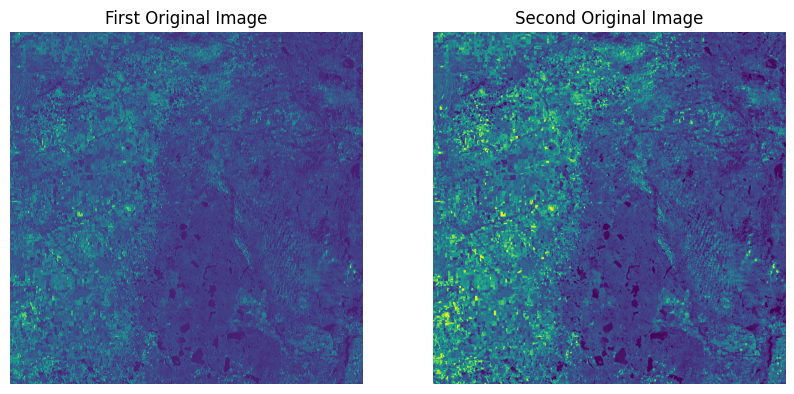

In [68]:
# Plot original images
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.title("First Original Image")
plt.imshow(first_original)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Second Original Image")
plt.imshow(second_original)
plt.axis('off')

plt.show()

In [69]:
# Using ResNet50 model to extract features
base_model = ResNet50(weights='imagenet', include_top=False)
model = tf.keras.Model(inputs=base_model.input, outputs=base_model.get_layer('conv5_block3_out').output)

In [70]:
def feature_map_extraction(img):
    """
    Function that extract feature maps from original image
    ims is original image
    """
    # Image preparation
    img = np.stack([img] * 3, axis=-1)
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor = preprocess_input(img_tensor)

    # Extract features using ResNet50
    feature_map = model.predict(img_tensor)

    return feature_map

In [71]:
first_feature_map = feature_map_extraction(first_band11)
second_feature_map = feature_map_extraction(second_band11)

1/1 ━━━━━━━━━━━━━━━━━━━━ 132s 132s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 118s 118s/step


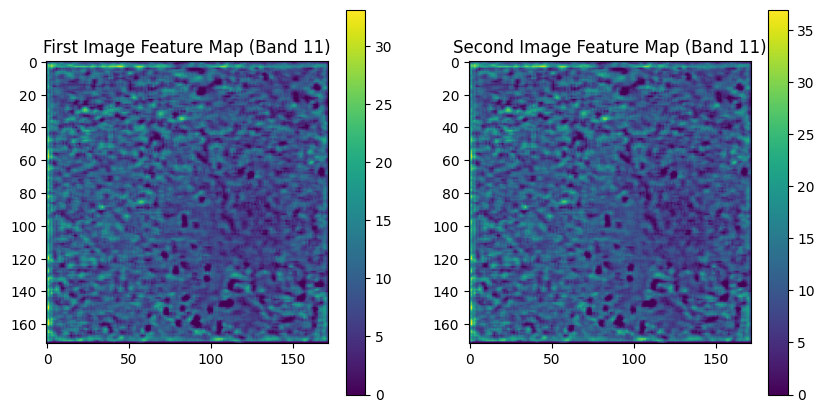

In [72]:
# Plot feature map sample
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.imshow(first_feature_map[0, :, :, 5], cmap='viridis')
plt.title("First Image Feature Map (Band 11)")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(second_feature_map[0, :, :, 5], cmap='viridis')
plt.title("Second Image Feature Map (Band 11)")
plt.colorbar()

plt.show()

In [73]:
def feature_map_to_2d(feature_map):
    """
    Function creating a 2d image from feature map
    """
    feature_map_2d = np.mean(feature_map[0], axis=-1)
    feature_map_2d = cv2.normalize(feature_map_2d, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    feature_map_2d = cv2.resize(first_original, (1080,1080))
    return feature_map_2d

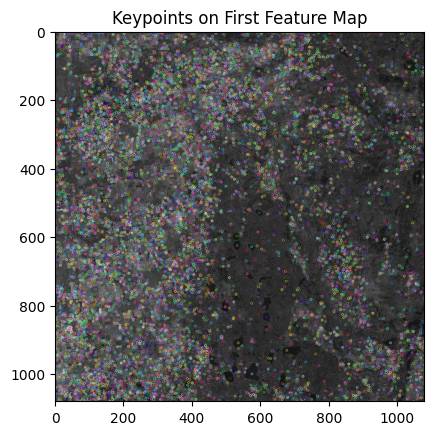

In [74]:
# Initialize the SIFT algorithm
sift = cv2.SIFT_create()

# Convert feature maps to 2D
first_feature_map_2d = feature_map_to_2d(first_feature_map)
second_feature_map_2d = feature_map_to_2d(second_feature_map)

# Detect keypoints and descriptors using SIFT
keypoints_1, descriptors_1 = sift.detectAndCompute(first_feature_map_2d, None)
keypoints_2, descriptors_2 = sift.detectAndCompute(second_feature_map_2d, None)

# Visualize keypoints on the first feature map
first_image_keypoints = cv2.drawKeypoints(first_feature_map_2d, keypoints_1, None)


plt.imshow(first_image_keypoints)
plt.title("Keypoints on First Feature Map")
plt.show()

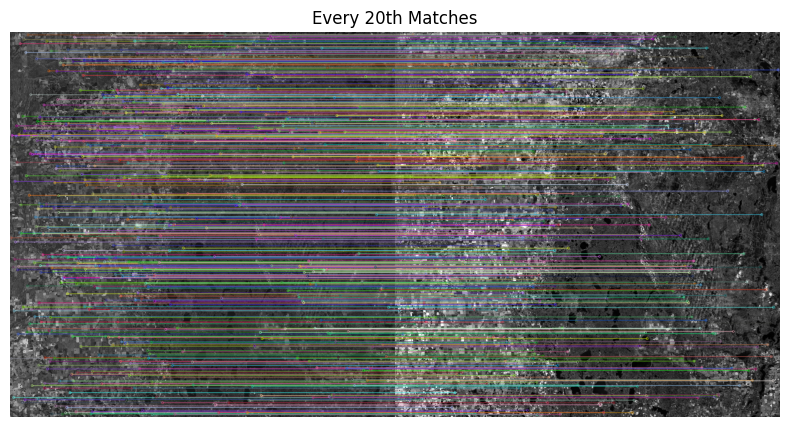

In [75]:
first_original_resized = cv2.resize(first_original, (1080,1080))
second_original_resized = cv2.resize(second_original, (1080,1080))

# Use the BFMatcher to find matches between the two sets of descriptors
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(descriptors_1, descriptors_2)

matches = sorted(matches, key=lambda x: x.distance)

# Drawing matches, but on the resized original images
matched_img = cv2.drawMatches(first_original_resized, keypoints_1, second_original_resized, keypoints_2, matches[::20], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

matched_img_rgb = cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB)
# Plot the matches on the resized original images
plt.figure(figsize=(10, 5))
plt.imshow(matched_img)
plt.title("Every 20th Matches")
plt.axis('off')
plt.show()
